# Weather Forecast - A Comprehensive Time-Series Investigation
---

# Importing the libraries

In [40]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Importing the dataset

Link to dataset: https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip

In [41]:
df = pd.read_csv('jena_climate_2009_2016.csv')

# Data preprocessing

In [42]:
df.shape

(420551, 15)

In [43]:
# starting from index 5 take every 6th record
df = df[5::6]

In [44]:
df.shape

(70091, 15)

In [45]:
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [46]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


## Evolution of some features with time

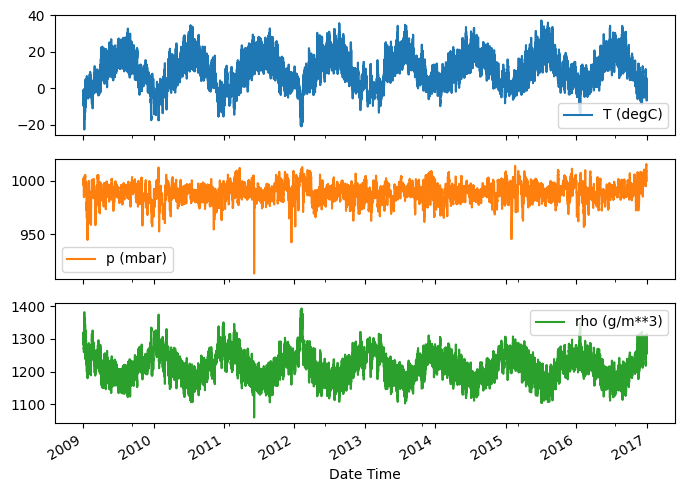

In [47]:
plot_columns = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']

plot_features = df[plot_columns]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

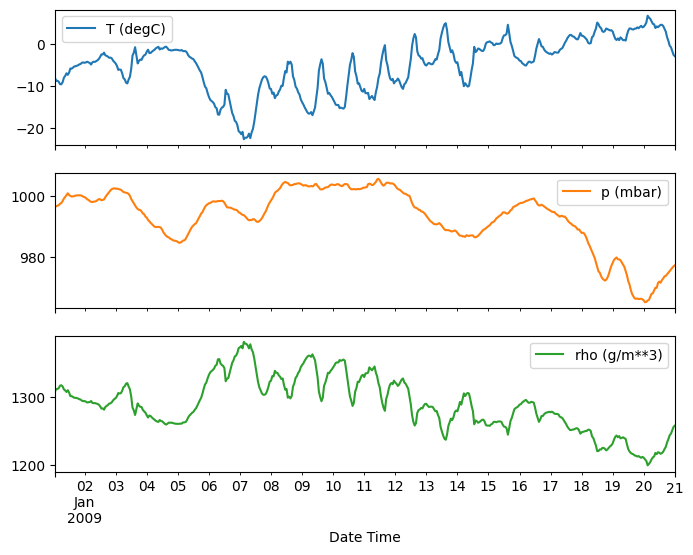

In [48]:
# first 480 rows

plot_features = df[plot_columns][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

## Cleaning the dataset

In [49]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


### Wind Velocity

You might notice that the wind velocity columns `wv (m/s)` and `max. wv (m/s)` contain a minimum value of `-9999`, which seems to be an error. 
Given that there is a separate column for wind direction, the wind velocity should always be greater than or equal to zero (`>=0`). 

To correct this, we should replace these -9999 values with zeros.

In [50]:
wind_vel = df['wv (m/s)']
bad_wind_vel = wind_vel == -9999.0
wind_vel[bad_wind_vel] = 0.0

max_wind_vel = df['max. wv (m/s)']
bad_max_wind_vel = max_wind_vel == -9999.0
max_wind_vel[bad_max_wind_vel] = 0.0

print(df['wv (m/s)'].min())
print(df['max. wv (m/s)'].min())

0.0
0.0


## Feature Engineering

Before starting to build a model, it’s crucial to have a good grasp of your data and ensure that you’re feeding the model data in the correct format.

### Wind

The wind direction column (wd (deg)) shows angles in degrees. However, angles aren't ideal for models because 0° and 360° should be treated as close to each other, representing a smooth wraparound. If the wind isn't blowing, the direction shouldn't affect the data.

Currently, the wind data distribution looks like this:

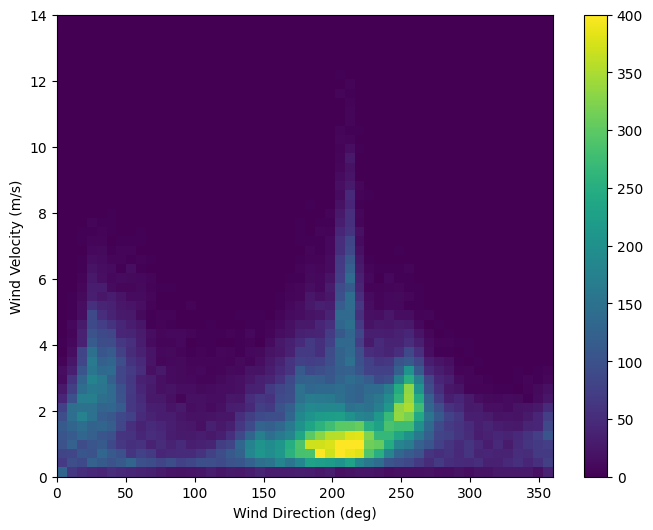

In [51]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction (deg)')
plt.ylabel('Wind Velocity (m/s)')
plt.show()

Converting the wind direction and velocity columns into a wind vector will make it easier for the model to interpret the data.

In [52]:
wind_vel = df.pop('wv (m/s)')
max_wind_vel = df.pop('max. wv (m/s)')

In [53]:
# Converting to radians.
wind_rad = df.pop('wd (deg)')*np.pi / 180

In [54]:
# Calculating the wind x and y components.
df['Wx'] = wind_vel*np.cos(wind_rad)
df['Wy'] = wind_vel*np.sin(wind_rad)

In [55]:
# Calculating the max wind x and y components.
df['max Wx'] = max_wind_vel*np.cos(wind_rad)
df['max Wy'] = max_wind_vel*np.sin(wind_rad)

The distribution of wind vectors is easier for the model to interpret accurately.

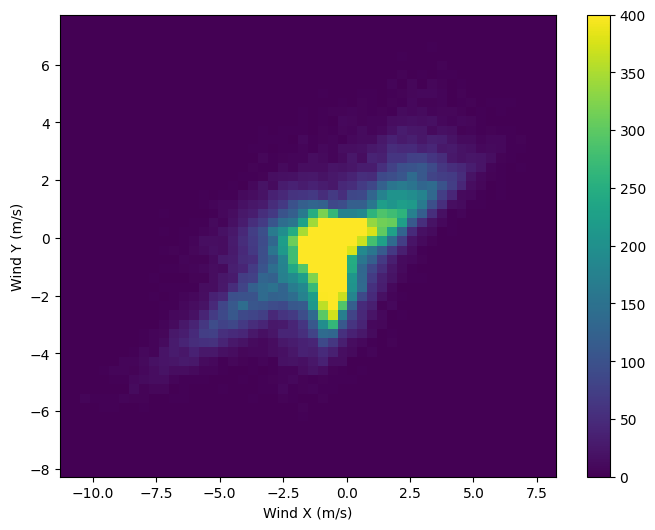

In [56]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X (m/s)')
plt.ylabel('Wind Y (m/s)')
ax = plt.gca()
ax.axis('tight')
plt.show()

### Time

Converting the `Date Time` column into pandas format is very useful to work with.

In [57]:
timestamp_sec = date_time.map(pd.Timestamp.timestamp)

Just like wind direction, time in seconds isn’t a helpful input for the model. Since this is weather data, it follows daily and yearly cycles. There are effective methods to handle periodicity. 

Using sine and cosine transformations can extract meaningful signals for "Time of day" and "Time of year" patterns, making the data more usable for modeling.

In [58]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_sec * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_sec * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_sec * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_sec * (2 * np.pi / year))

Plotting first 25 rows

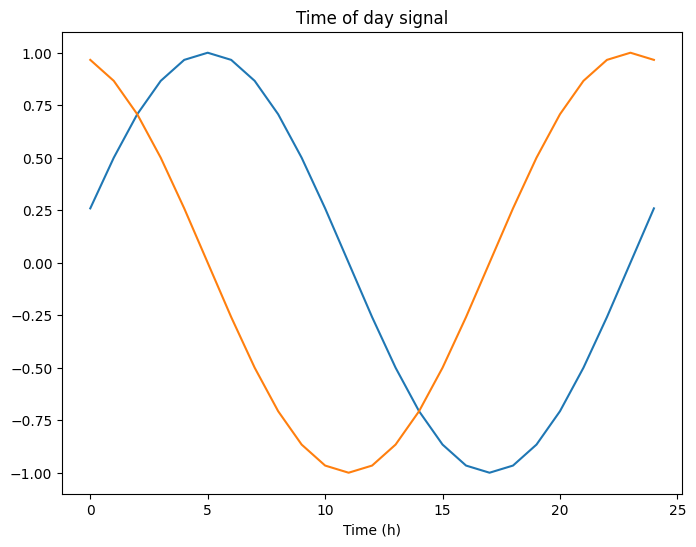

In [59]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time (h)')
plt.title('Time of day signal')
plt.show()

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

## Splitting the dataset

We will use `70%, 20%, 10%` split for training, validation and test sets. The data can not be shuffled randomly before splitting for two main reasons:

* It allows for creating windows of consecutive samples, maintaining temporal continuity.
* It ensures that the validation and test results reflect real-world scenarios, as they are evaluated on data collected after the model was trained.

In [60]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [61]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


In [63]:
train_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


In [64]:
val_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
294383,990.43,14.46,288.41,13.81,95.9,16.49,15.82,0.68,9.99,15.97,1192.35,-0.448741,-1.389328,-0.682332,-2.112540,0.537300,0.843391,-0.549225,-0.835674
294389,990.66,13.83,287.76,13.39,97.2,15.83,15.39,0.44,9.72,15.53,1195.44,-0.449278,-0.756670,-0.714760,-1.203793,0.737277,0.675590,-0.549824,-0.835280
294395,990.80,13.53,287.45,13.31,98.6,15.53,15.31,0.22,9.67,15.45,1196.90,-1.518657,0.592100,-2.608735,1.017103,0.887011,0.461749,-0.550423,-0.834886
294401,990.96,13.33,287.24,13.16,98.9,15.33,15.16,0.17,9.57,15.29,1198.00,-0.768007,-0.855958,-1.175385,-1.309988,0.976296,0.216440,-0.551021,-0.834491
294407,991.10,13.46,287.35,13.35,99.3,15.46,15.35,0.11,9.69,15.49,1197.54,-1.443201,-0.220841,-2.253766,-0.344875,0.999048,-0.043619,-0.551619,-0.834096


In [65]:
test_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
378491,1001.93,2.80,275.81,1.25,89.5,7.47,6.69,0.78,4.16,6.68,1261.61,2.674455,1.336933,3.908819,1.953979,-8.660254e-01,0.500000,0.937670,0.347527
378497,1002.38,2.75,275.72,0.67,86.1,7.45,6.41,1.04,3.99,6.40,1262.54,2.836975,0.944286,4.943357,1.645394,-7.071068e-01,0.707107,0.937919,0.346855
378503,1002.63,2.46,275.41,0.46,86.6,7.29,6.32,0.98,3.93,6.30,1264.24,2.748864,1.298208,3.553630,1.678276,-5.000000e-01,0.866025,0.938167,0.346183
378509,1002.48,1.93,274.90,0.82,92.3,7.03,6.48,0.54,4.03,6.47,1266.37,1.506908,1.919070,2.352999,2.996580,-2.588190e-01,0.965926,0.938415,0.345510
378515,1002.42,1.87,274.84,0.76,92.3,6.99,6.45,0.54,4.01,6.44,1266.63,3.037622,1.614452,4.565263,2.426371,-1.801868e-12,1.000000,0.938662,0.344837


## Normalizing the data

In [66]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [67]:
train_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224850,0.707179,-0.057983,1.428400
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366133,0.366112,-0.056960,1.428388


In [68]:
val_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
294383,0.213759,0.618351,0.597730,1.321003,1.207707,0.407409,1.535799,-0.688716,1.526045,1.526654,-0.601703,0.072253,-0.639008,0.089478,-0.535618,0.759951,1.192787,-0.859306,-1.151853
294389,0.241478,0.545560,0.523229,1.260764,1.286231,0.321636,1.433619,-0.738532,1.424968,1.423369,-0.526259,0.071987,-0.233849,0.079109,-0.188724,1.042768,0.955490,-0.860161,-1.151299
294395,0.258351,0.510898,0.487698,1.249290,1.370796,0.282648,1.414609,-0.784197,1.406250,1.404590,-0.490612,-0.459268,0.629912,-0.526513,0.659056,1.254528,0.653085,-0.861015,-1.150745
294401,0.277634,0.487789,0.463629,1.227776,1.388917,0.256656,1.378964,-0.794575,1.368815,1.367032,-0.463755,-0.086355,-0.297434,-0.068182,-0.229261,1.380799,0.306181,-0.861869,-1.150190
294407,0.294506,0.502810,0.476236,1.255027,1.413079,0.273551,1.424114,-0.807029,1.413738,1.413979,-0.474987,-0.421783,0.109299,-0.413007,0.139150,1.412977,-0.061582,-0.862723,-1.149635


In [69]:
test_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
378491,1.599724,-0.728855,-0.846438,-0.480418,0.821124,-0.764821,-0.633744,-0.667960,-0.656453,-0.654069,1.089310,1.623820,1.106908,1.557556,1.016688,-1.224696,0.707179,1.262942,0.511342
378497,1.653958,-0.734632,-0.856754,-0.563604,0.615753,-0.767420,-0.700280,-0.613992,-0.720093,-0.719796,1.112016,1.704558,0.855454,1.888362,0.898892,-0.999946,1.000059,1.263298,0.510397
378503,1.684087,-0.768139,-0.892285,-0.593724,0.645954,-0.788214,-0.721666,-0.626446,-0.742555,-0.743270,1.153523,1.660785,1.082109,1.443980,0.911444,-0.707046,1.224794,1.263652,0.509452
378509,1.666010,-0.829376,-0.950739,-0.542091,0.990254,-0.822003,-0.683646,-0.717775,-0.705119,-0.703364,1.205528,1.043796,1.479713,1.060063,1.414679,-0.365957,1.366069,1.264006,0.508506
378515,1.658778,-0.836308,-0.957616,-0.550696,0.990254,-0.827201,-0.690775,-0.717775,-0.712606,-0.710407,1.211876,1.804237,1.284633,1.767462,1.197013,0.000077,1.414255,1.264359,0.507561


Take a look at the distribution of the features. While some features exhibit long tails, there are no evident errors such as the `-9999` wind velocity value.

C:\Users\jamal\AppData\Local\Temp\ipykernel_10764\3214313372.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df.keys(), rotation=90)


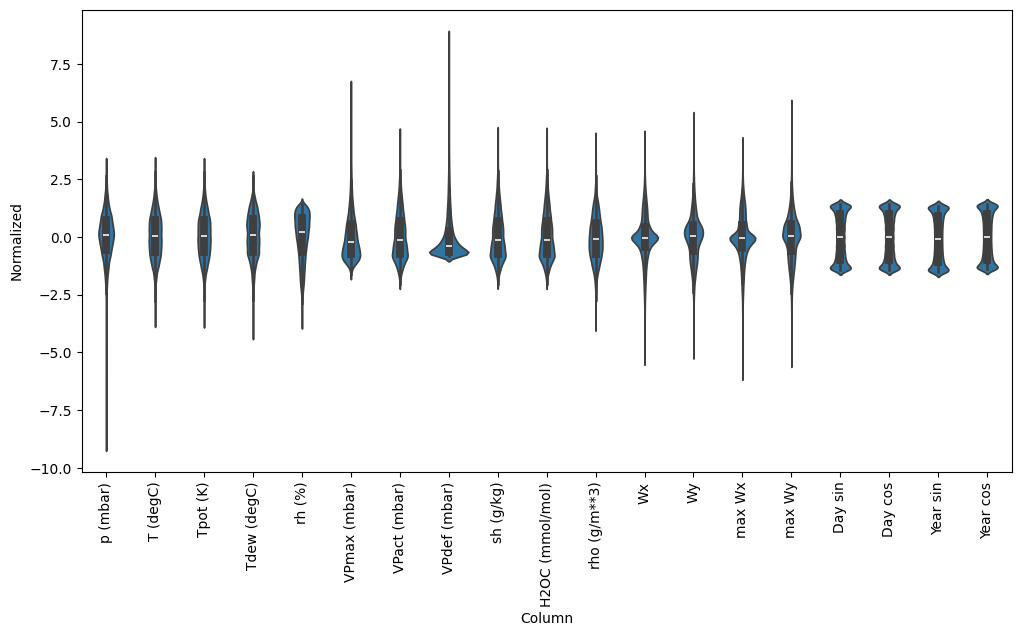

In [70]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data Windowing

The models that we will be building next will make a set of predictions using the windows of consecutive samples from the data.

### WindowGenerator class

We will first create the `WindowGenerator` class.

In [74]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    
    # Storing data
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Working with label column indices
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Working with window parameters
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total Window Size: {self.total_window_size}',
        f'Input Indices: {self.input_indices}',
        f'Label Indices: {self.label_indices}',
        f'Label Column Name(s): {self.label_columns}'])

### Indices and offsets for creating windows

for model that would predict 24 hours into the future

In [75]:
window_1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
window_1

Total Window Size: 48
Input Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label Indices: [47]
Label Column Name(s): ['T (degC)']

for model that would predict 1 hour into the future

In [76]:
window_2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
window_2

Total Window Size: 7
Input Indices: [0 1 2 3 4 5]
Label Indices: [6]
Label Column Name(s): ['T (degC)']

### Split window

for window 2

In [77]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing does not preserve static shape information, so set the shapes manually. 
  # This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

for example

In [80]:
example_window = tf.stack([np.array(train_df[:window_2.total_window_size]),
                           np.array(train_df[100:100+window_2.total_window_size]),
                           np.array(train_df[200:200+window_2.total_window_size])])

example_inputs, example_labels = window_2.split_window(example_window)

print('All shapes are in the format (batch, time, features)')
print(f'\nWindow Shape: {example_window.shape}')
print(f'Inputs Shape: {example_inputs.shape}')
print(f'Labels Shape: {example_labels.shape}')

All shapes are in the format (batch, time, features)

Window Shape: (3, 7, 19)
Inputs Shape: (3, 6, 19)
Labels Shape: (3, 1, 1)


The provided code processes a batch consisting of three windows, each containing 7 time steps with 19 features per time step. It transforms this batch into a set of inputs with 6 time steps and 19 features, along with a single-label output with 1 time step and 1 feature. The label contains only one feature due to initializing the `WindowGenerator` with `label_columns=['T (degC)']`. Initially, this tutorial will focus on building models that predict single output labels.

In TensorFlow, data is usually organized into arrays with the outermost index representing examples (the "batch" dimension). The middle indices correspond to the "time" or "space" (width, height) dimension(s), while the innermost indices represent the features.

### Plotting the split window

In [81]:
window_2.example = example_inputs, example_labels

In [82]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot shows the inputs, labels and the predicted value with `green` dot using the previous 6 values.

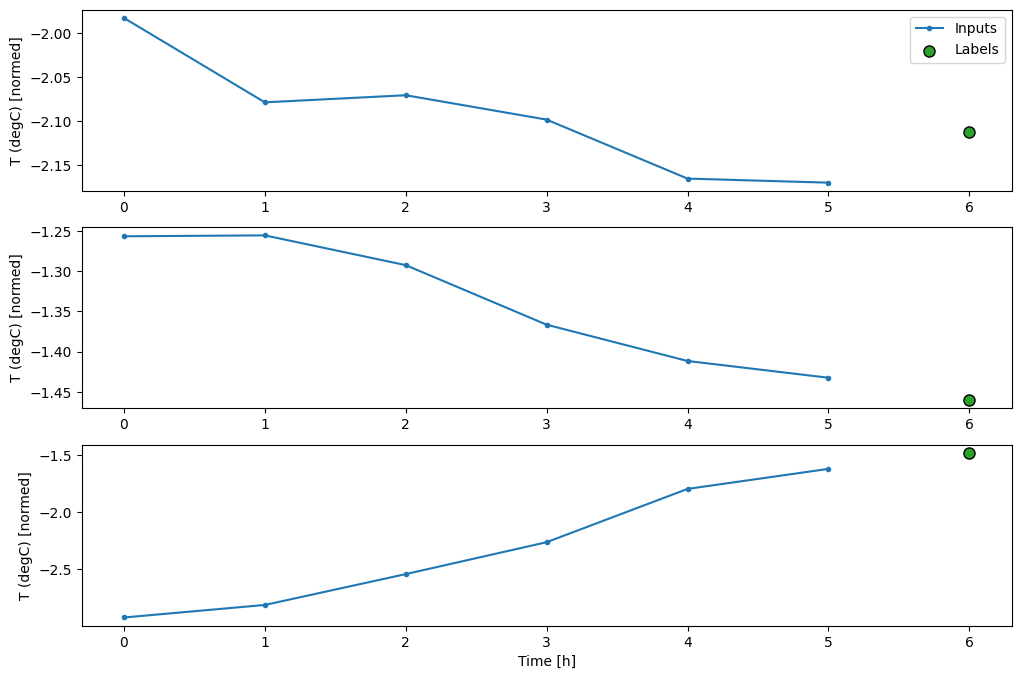

In [83]:
window_2.plot()

### Creating tf.data.Datasets

In [84]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

Adding properties for accessing as `tf.data.Dataset`s using the `make_dataset` method we defined earlier. Also, adding a standard example batch for easy access and plotting.

In [85]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [86]:
# Each element is an (inputs, label) pair

window_2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over `Dataset` to yield concrete batches

In [87]:
for example_inputs, example_labels in window_2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


# Single Step Models

These are the simple model that can predict one step ahead in the future using historical data.

So, we will first starting to build models to predict the `T (degC)` value one hour into the future.

We will first configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs.

In [89]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])

single_step_window

Total Window Size: 2
Input Indices: [0]
Label Indices: [1]
Label Column Name(s): ['T (degC)']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing us to easily iterate over batches of data.

In [90]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs Shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels Shape (batch, time, features): {example_labels.shape}')

Inputs Shape (batch, time, features): (32, 1, 19)
Labels Shape (batch, time, features): (32, 1, 1)


## Baseline model

Before we move to build the model, it would be better to have a performance baseline as benchmark for comparison with the later models.

In [91]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    
    return result[:, :, tf.newaxis]

In [92]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 3ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


Creating a wider `WindowGenerator` that gives windows 24 hours of consecutive inputs and labels at a time to plot and visualize easily.

In [93]:
wider_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wider_window

Total Window Size: 25
Input Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label Indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label Column Name(s): ['T (degC)']

In [96]:
print('Input Shape:', wider_window.example[0].shape)
print('Output Shape:', baseline(wider_window.example[0]).shape)

Input Shape: (32, 24, 19)
Output Shape: (32, 24, 1)


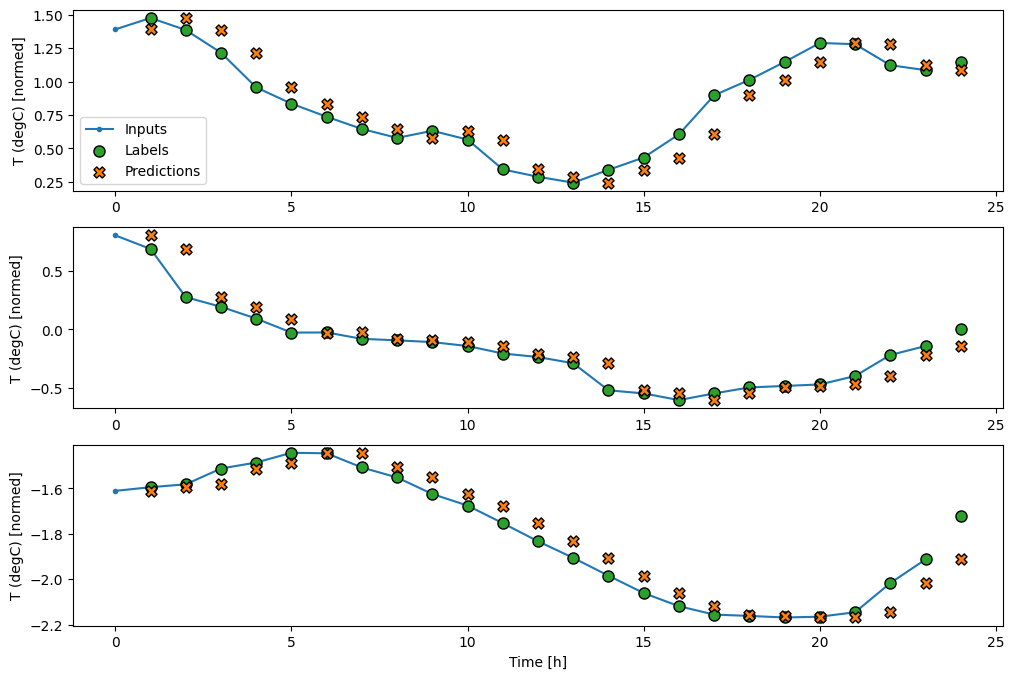

In [97]:
wider_window.plot(baseline)

The above plots of three examples the single step model of 24 hours run.

- The blue line labeled Inputs represents the input temperature at each time step. While the model receives all features, this plot focuses only on temperature data.
- The green dots labeled Labels indicate the target prediction values. These dots are positioned at the prediction time, not at the input time. Thus, the range of labels is shifted by 1 step relative to the inputs.
- The orange crosses labeled Predictions represent the model's predictions for each output time step. Ideally, if the model predicted perfectly, these crosses would align directly with the Labels.

## Linear model

In [98]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [99]:
print('Input Shape:', single_step_window.example[0].shape)
print('Output Shape:', linear(single_step_window.example[0]).shape)

Input Shape: (32, 1, 19)
Output Shape: (32, 1, 1)


In [100]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  
  return history

Training the model

In [101]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 8s 4ms/step - loss: 0.1435 - mean_absolute_error: 0.2247 - val_loss: 0.0105 - val_mean_absolute_error: 0.0751
Epoch 2/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0101 - mean_absolute_error: 0.0737 - val_loss: 0.0095 - val_mean_absolute_error: 0.0717
Epoch 3/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0097 - mean_absolute_error: 0.0723 - val_loss: 0.0092 - val_mean_absolute_error: 0.0712
Epoch 4/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0095 - mean_absolute_error: 0.0717 - val_loss: 0.0092 - val_mean_absolute_error: 0.0714
Epoch 5/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0094 - mean_absolute_error: 0.0714 - val_loss: 0.0091 - val_mean_absolute_error: 0.0706
Epoch 6/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0094 - mean_absolute_error: 0.0710 - val_loss: 0.0090 - val_mean_absolute_error: 0.0702
Epoc

In [102]:
print('Input Shape:', wider_window.example[0].shape)
print('Output Shape:', baseline(wider_window.example[0]).shape)

Input Shape: (32, 24, 19)
Output Shape: (32, 24, 1)


Plot of the linear model

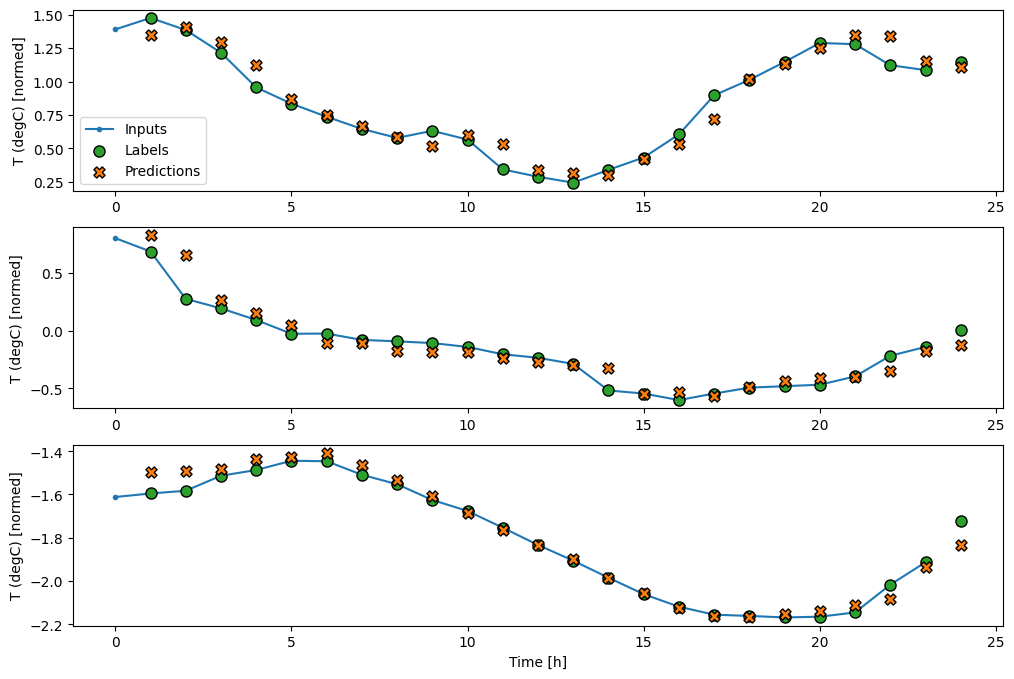

In [103]:
wider_window.plot(linear)

Visualizing the model weights

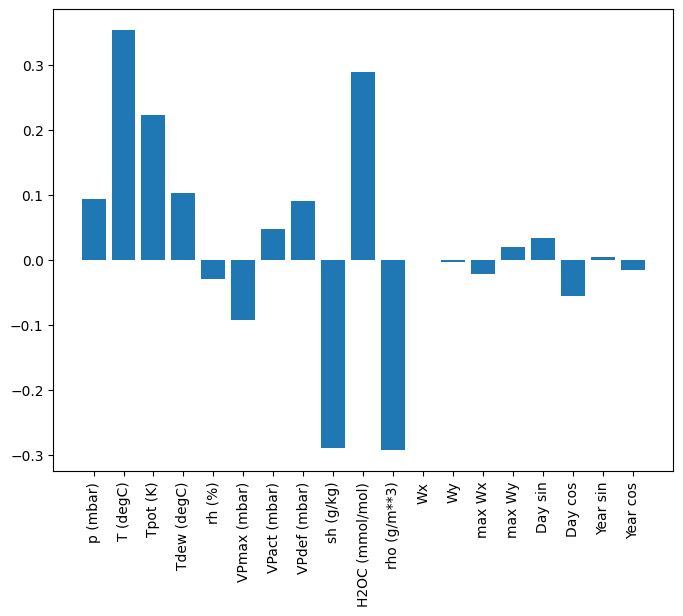

In [104]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense

In [105]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 15s 9ms/step - loss: 0.0159 - mean_absolute_error: 0.0793 - val_loss: 0.0074 - val_mean_absolute_error: 0.0626
Epoch 2/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0077 - mean_absolute_error: 0.0634 - val_loss: 0.0073 - val_mean_absolute_error: 0.0610
Epoch 3/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0074 - mean_absolute_error: 0.0617 - val_loss: 0.0068 - val_mean_absolute_error: 0.0582
Epoch 4/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0071 - mean_absolute_error: 0.0603 - val_loss: 0.0069 - val_mean_absolute_error: 0.0596
Epoch 5/20
439/439 [==============================] - 2s 4ms/step - loss: 0.0071 - mean_absolute_error: 0.0613


Plot of the dense model

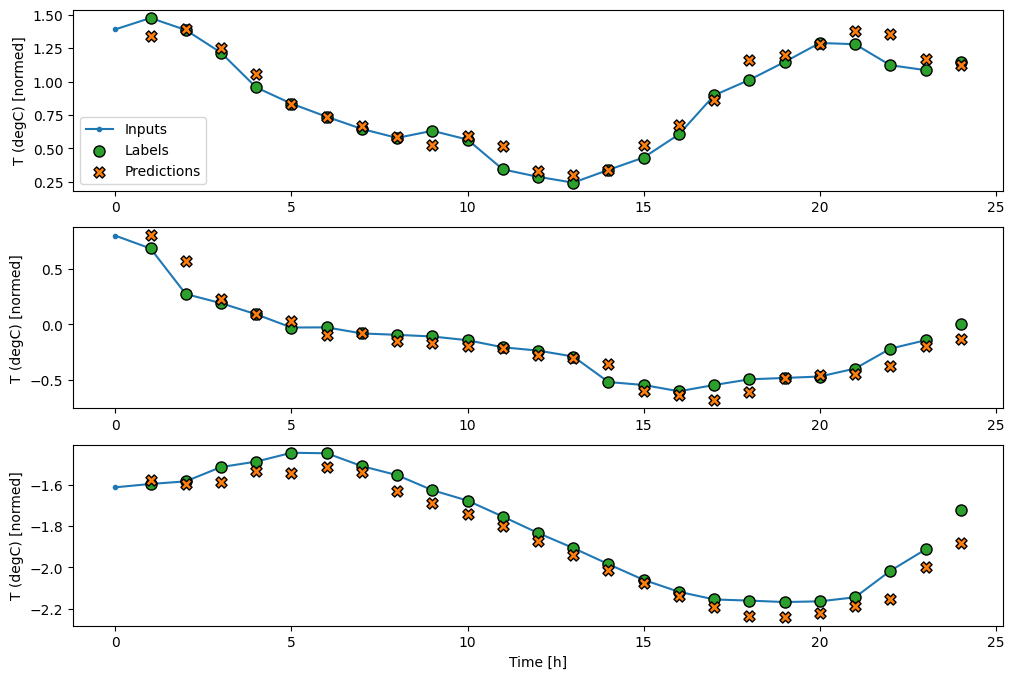

In [106]:
wider_window.plot(dense)

## Convolutional Neural Network (CNN)

A convolutional neural network (CNN), take mulitple time steps when making predictions.

The `baseline`, `linear` and `dense` models handled each time step independently as one step. Here, this model will take multiple time steps as input to produce a single output in the future.

For this we will first create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels.

In [111]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

print(conv_window)

Total Window Size: 4
Input Indices: [0 1 2]
Label Indices: [3]
Label Column Name(s): ['T (degC)']


In [112]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [121]:
print("CNN model on `conv_window`")
print('\nInput Shape:', conv_window.example[0].shape)
print('Output Shape:', cnn(conv_window.example[0]).shape)

CNN model on `conv_window`

Input Shape: (32, 3, 19)
Output Shape: (32, 1, 1)


In [114]:
history = compile_and_fit(cnn, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = cnn.evaluate(conv_window.val)
performance['Conv'] = cnn.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 2s 3ms/step - loss: 0.0075 - mean_absolute_error: 0.0639


The convolutional layer can be applied to a sliding window of inputs. You can also run it on a wider input, it will produce the wider output.

In [120]:
print("Wider Window")
print('\nInput Shape:', wider_window.example[0].shape)
print('Labels Shape:', wider_window.example[1].shape)
print('Output Shape:', cnn(wider_window.example[0]).shape)

Wider Window

Input Shape: (32, 24, 19)
Labels Shape: (32, 24, 1)
Output Shape: (32, 22, 1)


Note:

The output is always shorter than the input. So, to make the training or plotting work, we need the labels, and prediction to have the same length. So, we will build a `WindowGenerator` to produce wide windows with a few extra input time steps so that the label and prediction lengths match each other.

In [117]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wider_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wider_conv_window

Total Window Size: 27
Input Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label Indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label Column Name(s): ['T (degC)']

In [122]:
print("Wider Conv Window")
print('\nInput Shape:', wider_conv_window.example[0].shape)
print('Labels Shape:', wider_conv_window.example[1].shape)
print('Output Shape:', cnn(wider_conv_window.example[0]).shape)

Wider Conv Window

Input Shape: (32, 26, 19)
Labels Shape: (32, 24, 1)
Output Shape: (32, 24, 1)


Plotting of the cnn model

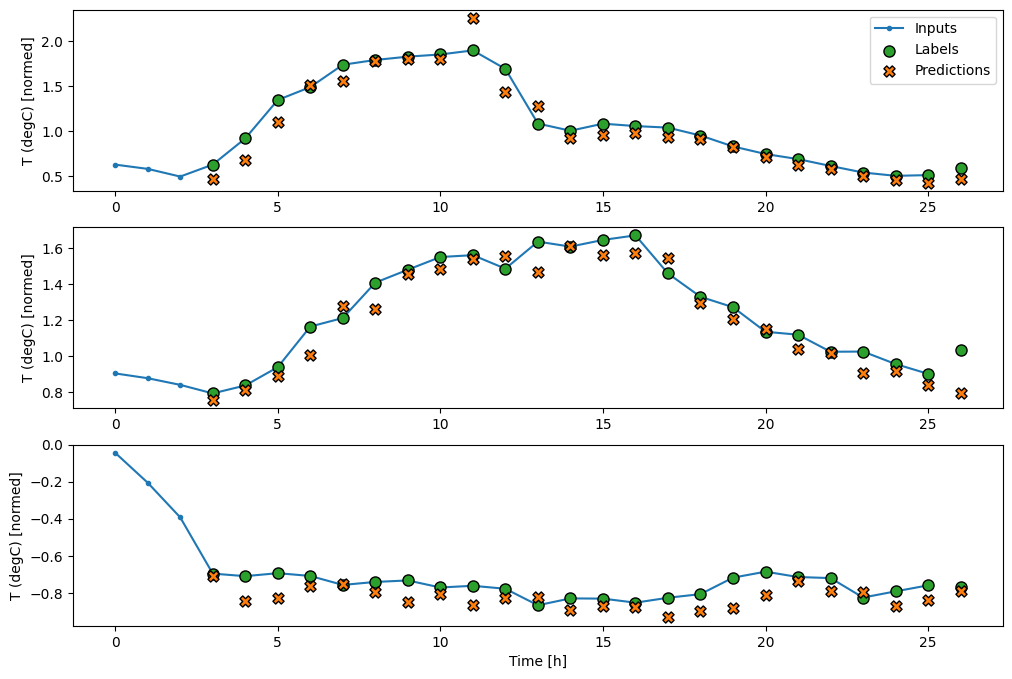

In [123]:
wider_conv_window.plot(cnn)

## Recurrent Neural Network (RNN)

An RNN (Recurrent Neural Network) is a neural network type particularly effective for time series data. RNNs analyze time series data incrementally, retaining an internal state as they process each time step.

In [124]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [126]:
print('Input Shape:', wider_window.example[0].shape)
print('Output Shape:', lstm_model(wider_window.example[0]).shape)

Input Shape: (32, 24, 19)
Output Shape: (32, 24, 1)


In [127]:
history = compile_and_fit(lstm_model, wider_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wider_window.val)
performance['LSTM'] = lstm_model.evaluate(wider_window.test, verbose=0)

438/438 [==============================] - 4s 9ms/step - loss: 0.0056 - mean_absolute_error: 0.0519


Plot of the rnn model

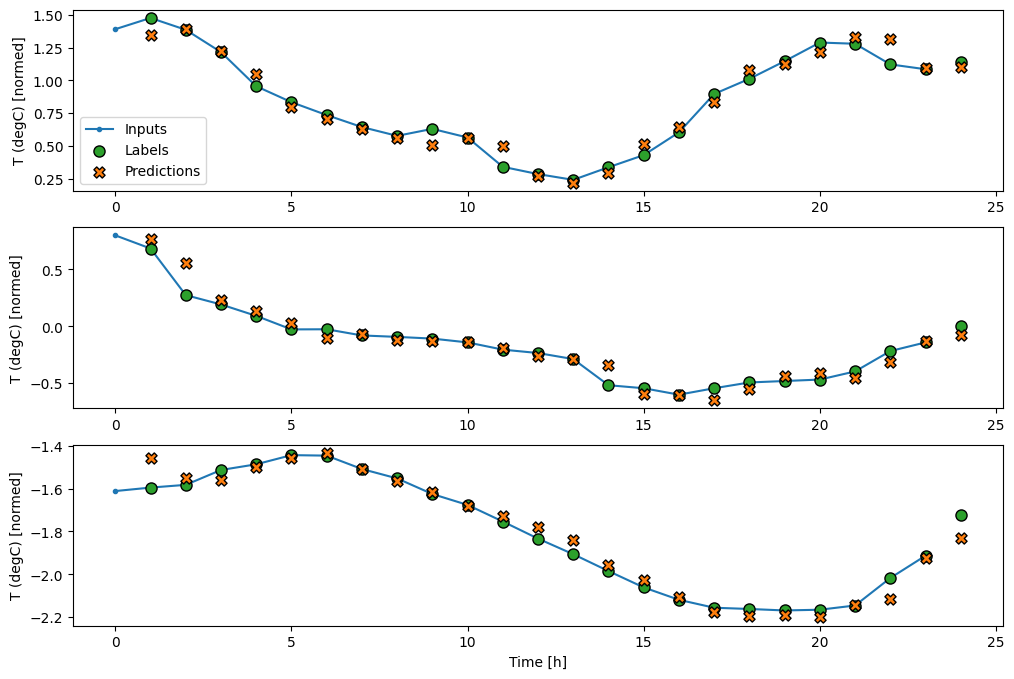

In [128]:
wider_window.plot(lstm_model)

## Performance

As we can see the above plots of each model, one can observe that typically each of the model does slightly better than the one before it.

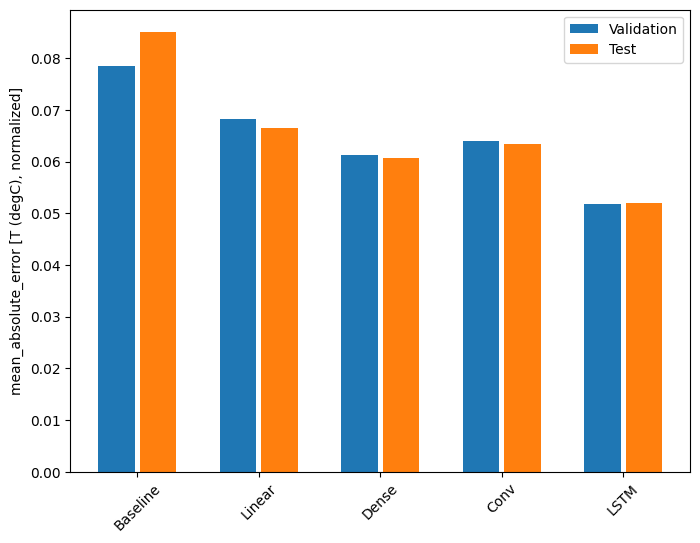

In [129]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [130]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0665
Dense       : 0.0607
Conv        : 0.0634
LSTM        : 0.0521


# Multi-Step Models

Multi-step models needs to learn to predict a range of future values. Unlike, single-step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two approaches:

- Single shot predictions
- Autoregressive predictions

In the multi-step model, the training data comprises hourly samples. The models are trained to forecast 24 hours ahead based on the preceding 24 hours of data.

Below is a `Window` object used to create these data slices from the dataset.

Total Window Size: 48
Input Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label Indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label Column Name(s): None

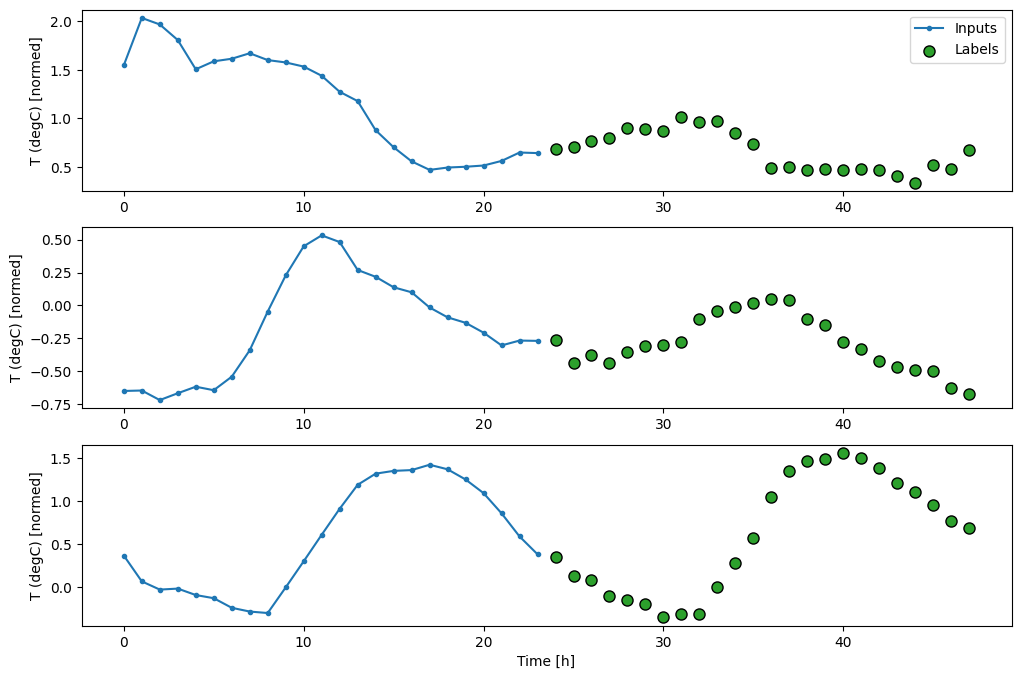

In [131]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

## Baseline Model

A basic starting point for this task is to use the value from the last input time step and repeat it for the necessary number of output time steps.

437/437 [==============================] - 2s 4ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


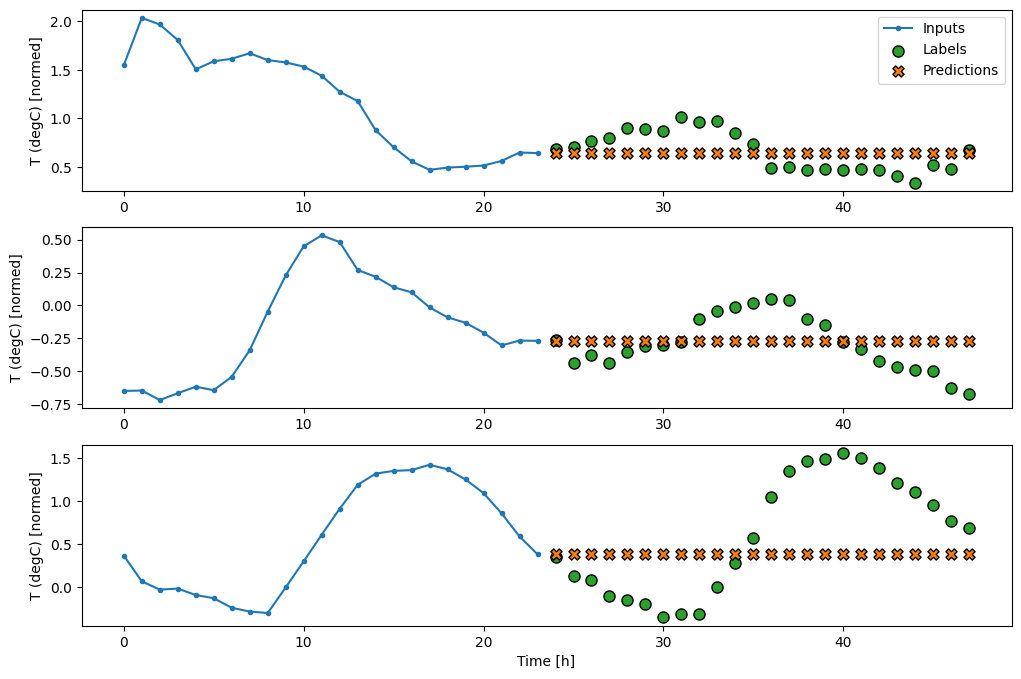

In [132]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Another straightforward approach for predicting 24 hours into the future, given 24 hours of past data, is to duplicate the data from the previous day, assuming that tomorrow will exhibit similar patterns.

437/437 [==============================] - 2s 4ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


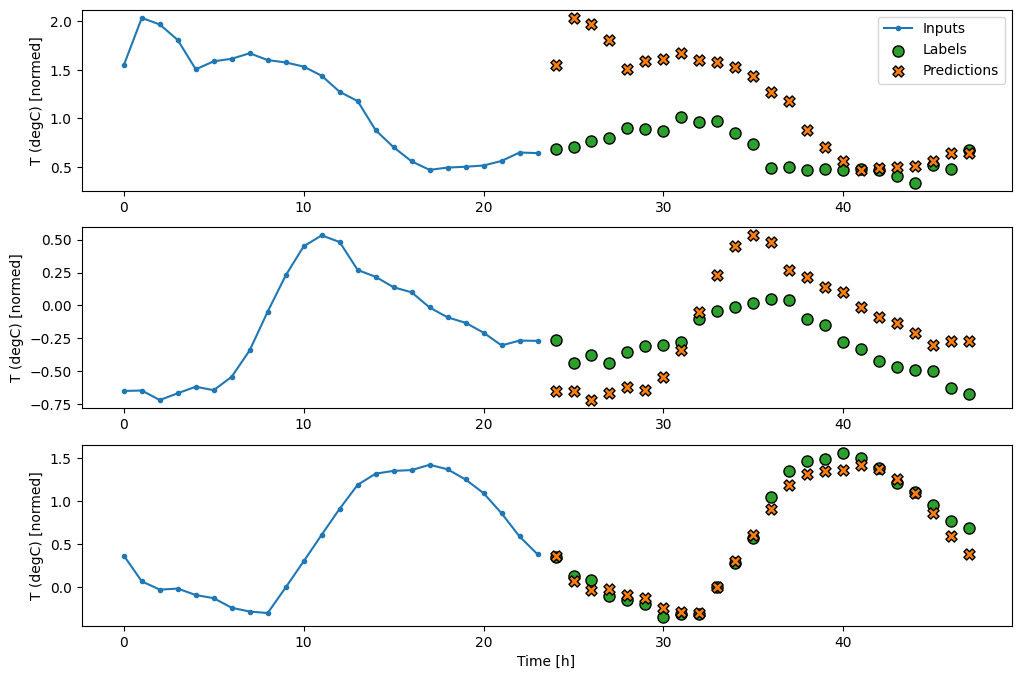

In [133]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## Single-Shot Models

One overarching strategy for this issue involves employing a "single-shot" model, where the model generates predictions for the entire sequence in one step.

We can implement this efficiently using a `tf.keras.layers.Dense` layer with `OUT_STEPS*features` output units. The model then simply needs to reshape the output to the desired `(OUTPUT_STEPS, features)` format.

### Linear

A basic linear model using the last input time step outperforms both baselines, although it lacks power. This model is tasked with predicting `OUTPUT_STEPS` time steps from a single input time step through a linear projection. Its capabilities are limited to capturing a low-dimensional aspect of the behavior, primarily influenced by the time of day and time of year.

437/437 [==============================] - 2s 3ms/step - loss: 0.2560 - mean_absolute_error: 0.3052


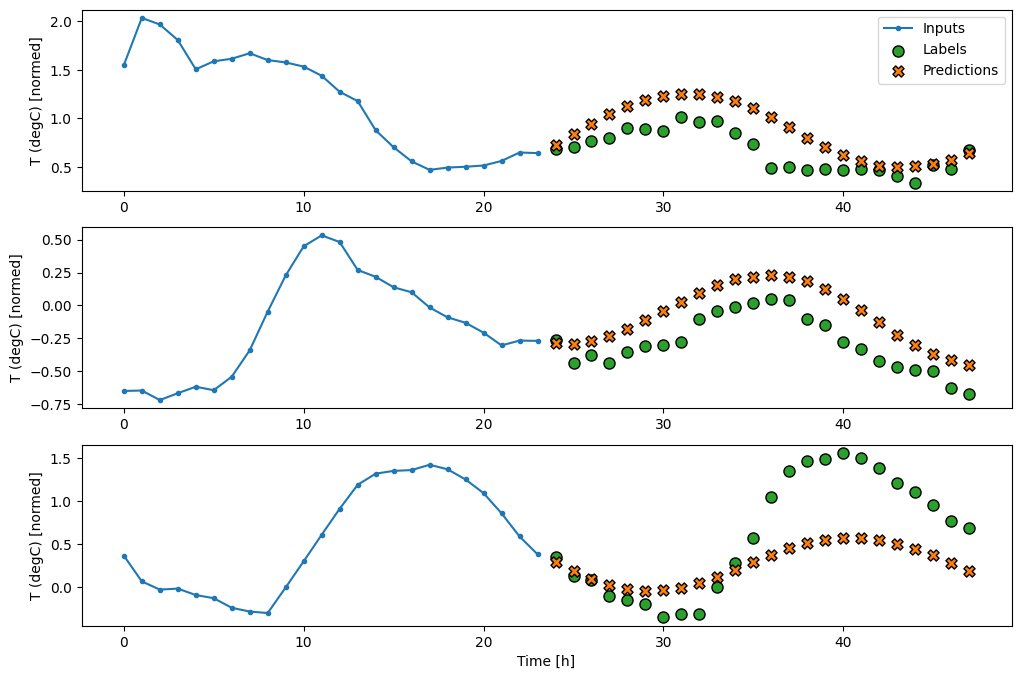

In [134]:
multi_linear_model = tf.keras.Sequential([
    # Taking the last time-step
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### Dense

Introducing a `tf.keras.layers.Dense` layer between the input and output provides the linear model with increased capability, although it still relies solely on a single input time step.







437/437 [==============================] - 3s 7ms/step - loss: 0.2193 - mean_absolute_error: 0.2819


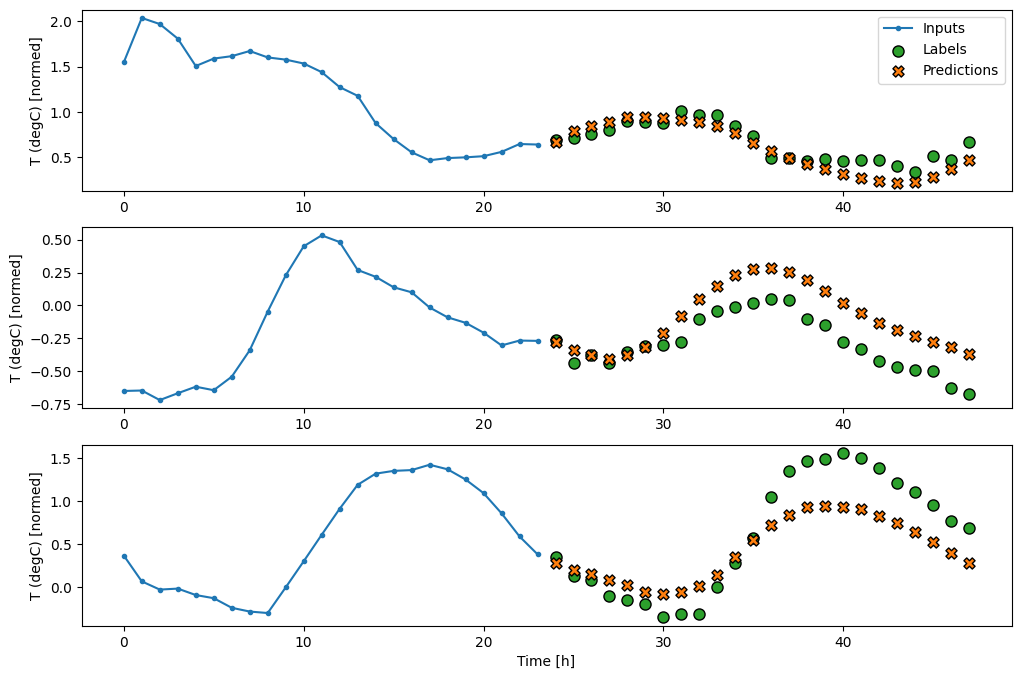

In [135]:
multi_dense_model = tf.keras.Sequential([
    # Taking the last time step
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

### Convolutional Neural Networks (CNN)


A convolutional model predicts outcomes based on a fixed-width historical context, potentially offering superior performance compared to the dense model. This is because it can capture temporal changes effectively.

437/437 [==============================] - 3s 5ms/step - loss: 0.2176 - mean_absolute_error: 0.2821


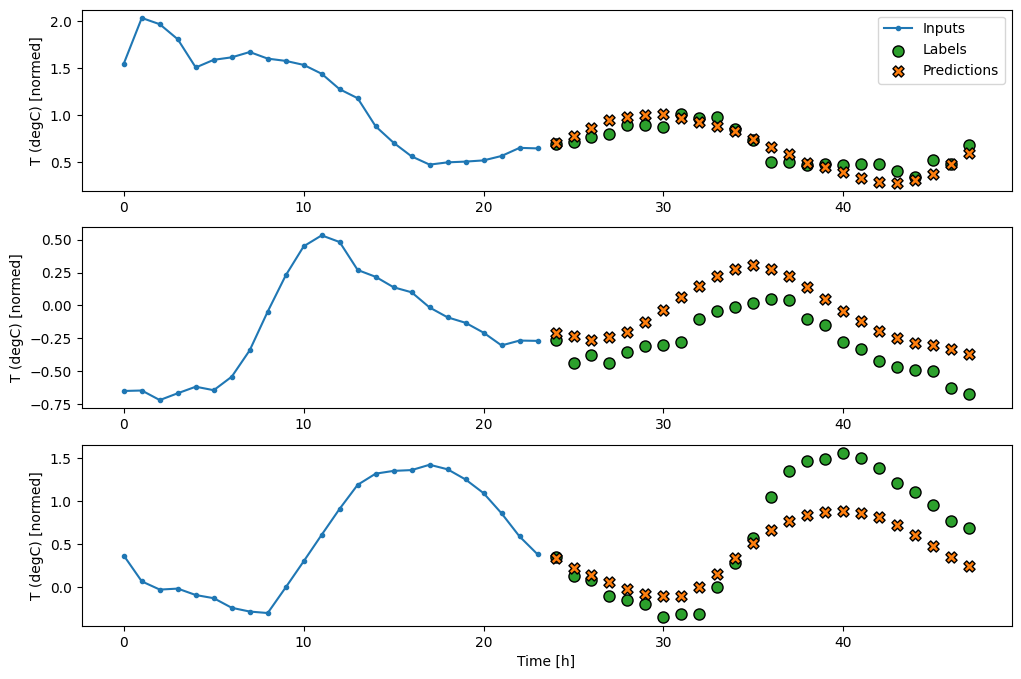

In [136]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

### Recurrent Neural Networks (RNN)

A recurrent model can leverage a lengthy input history if it's pertinent to the predictions being made. In this context, the model will gather internal state information over 24 hours before generating a single prediction for the subsequent 24 hours.

In this single-shot configuration, the LSTM only needs to generate an output at the final time step, so ensure to set `return_sequences=False` in `tf.keras.layers.LSTM`.

437/437 [==============================] - 3s 7ms/step - loss: 0.2154 - mean_absolute_error: 0.2850


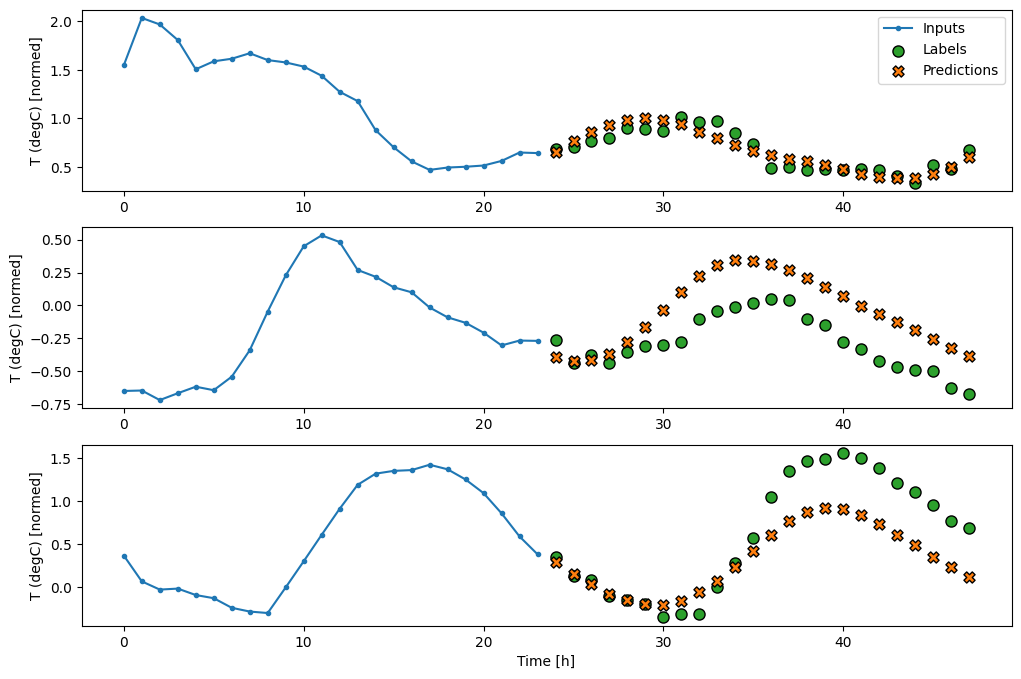

In [137]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## Autoregressive Model

In this approach, each model's output becomes the input for the subsequent step, allowing predictions conditioned on previous ones.

In [138]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [139]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

To begin, the model requires a `warmup` method to set up its internal state using the input data. After training, this state will encapsulate pertinent aspects of the input history. Essentially, this mirrors the functionality of the single-step `LSTM` model discussed earlier.

In [140]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single-time step prediction and the internal state of the `LSTM` model.

In [141]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

Now using `RNN`'s state, we will continue iterating the model feeding the predictions at each step back as the input.

In [142]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Testing the model on example inputs

In [143]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Training the model

437/437 [==============================] - 4s 8ms/step - loss: 0.2254 - mean_absolute_error: 0.2996


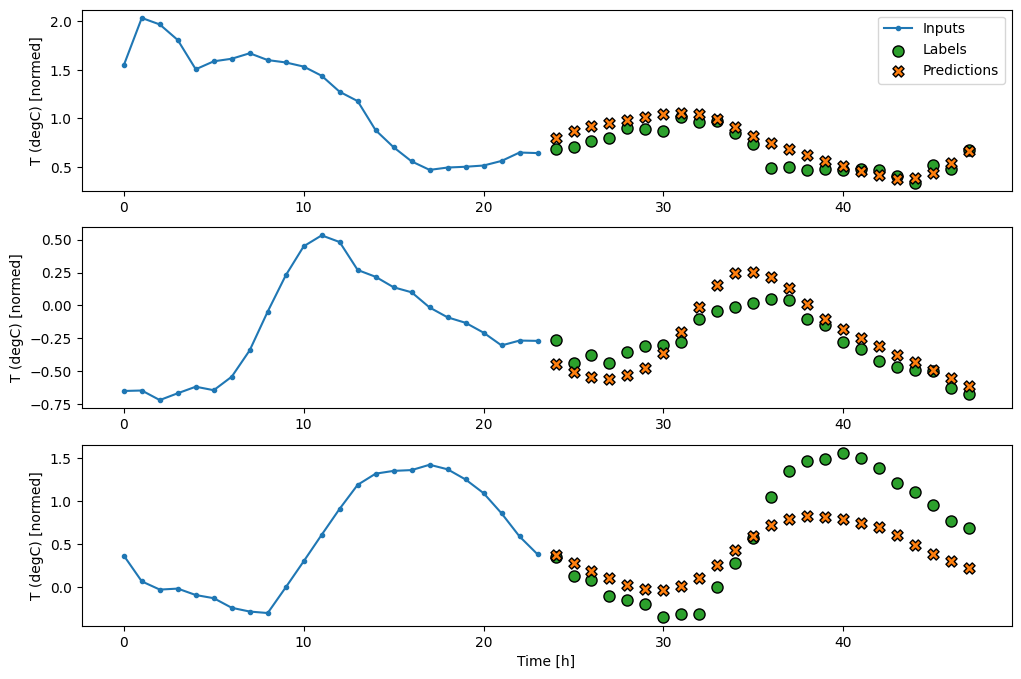

In [144]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

## Performance

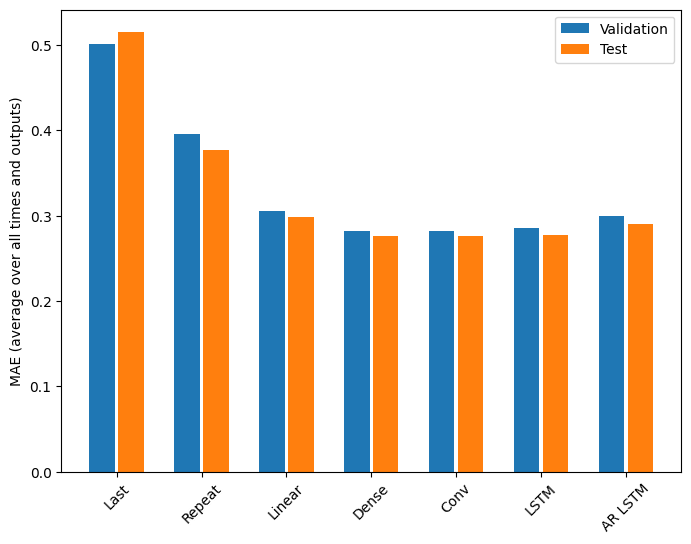

In [145]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models presented earlier in this tutorial represent performance averaged across all output features and time steps. This averaging results in similar performances across the models but obscures performance variations across different time steps and features.

In [146]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2980
Dense   : 0.2763
Conv    : 0.2762
LSTM    : 0.2778
AR LSTM : 0.2897


# Conclusion

Transitioning from a dense model to convolutional and recurrent models resulted in marginal gains, if any, while the autoregressive model exhibited notably poorer performance. Therefore, these more complex approaches might not be beneficial for this specific problem. However, without experimentation, it's impossible to ascertain their effectiveness, and they might still prove valuable for your problem.